# Calidad de Datos

### Temas:

- ¿Por qué preparar y validar los datos?
- Wrangling e imputación
- Interpolación
- Caso: Humedales
  - Scraping
  - Validación con Pydantic
- Normalización de strings:
  - Distancia de edición
  - Fuzzy string matching 

## Introducción

Es conocido el hecho de que, a la hora de trabajar con datos, la mayor parte no está en tunear algorítmos ni dejar bonitas las visualizaciones, si no en la preparación de los datos.

A la hora de avanzar con cualquier tipo de análisis basado en datos, es esencial previamente asegurarnos de que estamos trabajando con datos de calidad. Si no se dedica el tiempo necesario, y si consideramos que las empresas apoyan en los datos sus decisiones de negocio, los datos faltantes o incorrectos pueden impactar directamente en la performance de las mismas. Esto se potencia aún más si la toma de decisiones se vincula a modelos de aprendizaje automático, ya que datos de entrenamiento de mala calidad resultan en aprendizajes erróneos.

No solo pueden traer complicaciones en el sistema, sino que pueden traer un impacto importante al negocio y para los usuarios (por ejemplo, [Hawaiian Airlines se disculpa después de que una falla técnica causó miles de cargos fraudulentos](https://www.hawaiinewsnow.com/2019/05/24/hawaiian-air-apologizes-after-some-customers-were-overcharged-hundreds-thousands-dollars/))

Tener datos de calidad va a proveer muchas ventajas, tales como:
- Transparencia en los procesos
- Mayor confianza en las propias decisiones de negocio
- Escalabilidad
- Ahorro de costos y tiempo

<img src='https://crunchingthedata.com/wp-content/uploads/2021/04/Case-study-one_-Data-quality-copy-2.jpg' width="700px">

La calidad puede referir a la **extensión** o a la **intención** de la data:
- En terminos de extensión:
  - Una base completa (sin nulos)
  - **Consistencia** de las categorías. Por ejemplo, si una columna tiene categorías de talles S, M o L, sería inconsistente que aparezcan talles de calzado que siguen otro criterio, del tipo numérico en este caso (talle 40, 41, etc.)
  - **Precisión** de los datos: Que no tengan errores sintácticos (por ejemplo "Ss" en vez de "S") ni semánticos (por ejemplo "M" en vez de "S"). 


In [ ]:
import pandas as pd
import numpy as np

## Ejemplos de datos ruidosos

Cargamos nuestro csv movies.csv

Chequeando la calidad de nuestros datos:

In [ ]:
df = pd.read_csv("https://unket.s3.sa-east-1.amazonaws.com/data/movies.csv")

In [ ]:
df.head()

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,(2021),"\nAction, Horror, Thriller",6.1,\nA woman with a mysterious illness is forced ...,\n Director:\nPeter Thorwarth\n| \n Star...,"21,062",121.0,NaN
1,Masters of the Universe: Revelation,(2021– ),"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...","17,870",25.0,NaN
2,The Walking Dead,(2010–2022),"\nDrama, Horror, Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,"\n \n Stars:\nAndrew Lincoln, \n...","885,805",44.0,NaN
3,Rick and Morty,(2013– ),"\nAnimation, Adventure, Comedy",9.2,\nAn animated series that follows the exploits...,"\n \n Stars:\nJustin Roiland, \n...","414,849",23.0,NaN
4,Army of Thieves,(2021),"\nAction, Crime, Horror",NaN,"\nA prequel, set before the events of Army of ...",\n Director:\nMatthias Schweighöfer\n| \n ...,NaN,NaN,NaN


## 1- Chequeamos que los tipos de datos asociados a cada columna sean los que corresponden con los que queremos.

In [ ]:
df.dtypes

MOVIES       object
YEAR         object
GENRE        object
RATING      float64
ONE-LINE     object
STARS        object
VOTES        object
RunTime     float64
Gross        object
dtype: object

Querríamos que la columna **year** sea numérica y asociada a un año. Vemos que es un objeto, para convertirlo en entero tendríamos que eliminar todos los strings o seleccionar solo la parte numérica de todas las filas.

En estos casos tan singulares vamos a usar **REGEX** (Regular Expressions). Esto refiere a secuencias de caracteres que conforman un patrón de búsquedas. 

Una página útil para interpretar Regex: https://regexr.com/

In [ ]:
# Por defecto nos trae la primera captura que tenga 1 o más cifras. Como tenemos algunas series de televisión (año de comienzo y año de fin), en esos casos vamos a tomar el año de inicio.

df['YEAR']=df['YEAR'].str.extract('(\d+)')

Como la extracción solo trae el año tipo string, tenemos que transformarla en variable numérica.

In [ ]:
df["YEAR"] = pd.to_numeric(df["YEAR"])

A las columna **VOTES** y **Gross** también la querríamos en tipo numérico para poder realizar operaciones.

¿Cómo haríamos para transformar esto?

In [ ]:
df["VOTES"]=df["VOTES"].str.replace(",","")

In [ ]:
df["VOTES"] = pd.to_numeric(df["VOTES"])

In [ ]:
# Observamos los valores de la columna Gross

df["Gross"][df["Gross"].notna()]

77       $75.47M
85      $402.45M
95       $89.22M
111     $315.54M
125      $57.01M
          ...   
5750      $0.09M
5770      $0.00M
5835      $0.01M
6056      $0.01M
6292      $0.14M
Name: Gross, Length: 460, dtype: object

In [ ]:
df["Gross"]=df["Gross"].str.replace("$","")
df["Gross"]=df["Gross"].str.replace("M","")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
df["Gross"] = pd.to_numeric(df["Gross"])

In [ ]:
df.dtypes

MOVIES       object
YEAR        float64
GENRE        object
RATING      float64
ONE-LINE     object
STARS        object
VOTES       float64
RunTime     float64
Gross       float64
dtype: object

## 2 - Tratamiento de los nulos

Los tipos de faltantes se pueden describir de la siguiente manera:

- Cuando no existe una relación sistemática entre los valores faltantes de una columna y otros valores o valores propios. Si la probabilidad de que falten es la misma para todos los casos, se dice que **los datos faltan completamente al azar (MCAR)**. Esto implica efectivamente que las causas de los datos que faltan no están relacionadas con los datos.

- Si la probabilidad de que falten es la misma solo dentro de los grupos definidos por los datos observados, entonces **los datos faltan al azar (MAR)**. MAR es una clase mucho más amplia que MCAR. Por ejemplo, cuando se coloca sobre una superficie blanda, una balanza puede producir más valores faltantes que cuando se coloca sobre una superficie dura. Por lo tanto, tales datos no son MCAR. Sin embargo, si conocemos el tipo de superficie y podemos suponer MCAR dentro del tipo de superficie, entonces los datos son MAR.

- Si ni MCAR ni MAR se cumplen, entonces hablamos de **datos perdidos no al azar (MNAR)**. MNAR significa que la probabilidad de que falte varía por razones que desconocemos. Por ejemplo, una encuesta de opinión pública en la que aquellos con opiniones más débiles responden con menos frecuencia. Son casos problemáticos porque los valores faltantes dependen de valores no observados.

### Imputaciones posibles

Al trabajar con un conjunto de datos que tienen valores nulos, podemos tomar varias decisiones. Una es eliminar esos datos y quedarnos con las filas que tengan datos para realizar un análisis en particular. Otra de las opciones, cuando no tenemos forma de acceder al dato que nos falta, es realizar imputaciones para poder usarlos en un posterior análisis.

Scikit-learn nos ofrece varias clases con las que se pueden realizar imputaciones de valores nulos en Python. Estas usan estadísticos tales como la media, la mediana o la moda. También existen otras opciones sustentadas en algoritmos más avanzados como los k-vecinos (ver KNN-Imputer)


In [ ]:
# Creamos el siguiente data que contiene valores nulos. 

data = pd.DataFrame({'id': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                     'area': [1, 2, 3, 1, 2, 3, 1, 2, 3],
                     'age': [32, 30, np.nan, 23, 27, 44, 67, 23, np.nan],
                     'amount': [102, 121, 343, np.nan, 121, np.nan, 155, 149, 221]})

In [ ]:
data

,id,area,age,amount
0,1,1,32.0,102.0
1,2,2,30.0,121.0
2,3,3,NaN,343.0
3,4,1,23.0,NaN
4,5,2,27.0,121.0
5,6,3,44.0,NaN
6,7,1,67.0,155.0
7,8,2,23.0,149.0
8,9,3,NaN,221.0


#### SimpleImputer

[SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) nos permite imputar un mismo valor a todos los registros nulos de una columna. Podemos usar la media, la mediana o la moda, o un valor constante que se indique. 

El método de cálculo se indica con la propiedad *strategy* que puede recibir como valor: mean, median, most_frequent o constant. En el caso de que el valor sea constant es necesario indicar mediante la propiedad fill_value.

In [ ]:
from sklearn.impute import SimpleImputer
simple = SimpleImputer().fit(data)
mean = simple.transform(data)

In [ ]:
# Como mean es un array, lo tenemos que asociar a un DataFrame. Además, con round(1) redondeamos el valor a un decimal.

data_media = pd.DataFrame(mean,columns=data.columns).round(1)

In [ ]:
data_media

,id,area,age,amount
0,1.0,1.0,32.0,102.0
1,2.0,2.0,30.0,121.0
2,3.0,3.0,35.1,343.0
3,4.0,1.0,23.0,173.1
4,5.0,2.0,27.0,121.0
5,6.0,3.0,44.0,173.1
6,7.0,1.0,67.0,155.0
7,8.0,2.0,23.0,149.0
8,9.0,3.0,35.1,221.0


Nos imputa el valor de la edad promedio (35,1) y el monto promedio (173,1).

En este caso, podríamos querer obtener números enteros, sin decimales, como en el resto de los registros, y podríamos usar la moda.

In [ ]:
simple = SimpleImputer(strategy='most_frequent')
mode = simple.fit_transform(data)

In [ ]:
data_moda = pd.DataFrame(mode,columns=data.columns)

In [ ]:
data_moda

,id,area,age,amount
0,1.0,1.0,32.0,102.0
1,2.0,2.0,30.0,121.0
2,3.0,3.0,23.0,343.0
3,4.0,1.0,23.0,121.0
4,5.0,2.0,27.0,121.0
5,6.0,3.0,44.0,121.0
6,7.0,1.0,67.0,155.0
7,8.0,2.0,23.0,149.0
8,9.0,3.0,23.0,221.0


Ahora el valor usado en la columna age es 23, mientras que para amount es 121.

## 3 - Volviendo a nuestra base: acercamos nuestro DataFrame de películas al criterio de Tidy Data.

In [ ]:
df#["STARS"]

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,STARS,VOTES,RunTime,Gross
0,Blood Red Sky,2021.0,"\nAction, Horror, Thriller",6.1,\nA woman with a mysterious illness is forced ...,\n Director:\nPeter Thorwarth\n| \n Star...,21062.0,121.0,NaN
1,Masters of the Universe: Revelation,2021.0,"\nAnimation, Action, Adventure",5.0,\nThe war for Eternia begins again in what may...,"\n \n Stars:\nChris Wood, \nSara...",17870.0,25.0,NaN
2,The Walking Dead,2010.0,"\nDrama, Horror, Thriller",8.2,\nSheriff Deputy Rick Grimes wakes up from a c...,"\n \n Stars:\nAndrew Lincoln, \n...",885805.0,44.0,NaN
3,Rick and Morty,2013.0,"\nAnimation, Adventure, Comedy",9.2,\nAn animated series that follows the exploits...,"\n \n Stars:\nJustin Roiland, \n...",414849.0,23.0,NaN
4,Army of Thieves,2021.0,"\nAction, Crime, Horror",NaN,"\nA prequel, set before the events of Army of ...",\n Director:\nMatthias Schweighöfer\n| \n ...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
9994,The Imperfects,2021.0,"\nAdventure, Drama, Fantasy",NaN,\nAdd a Plot\n,\n \n Stars:\nMorgan Taylor Camp...,NaN,NaN,NaN
9995,Arcane,2021.0,"\nAnimation, Action, Adventure",NaN,\nAdd a Plot\n,\n,NaN,NaN,NaN
9996,Heart of Invictus,2022.0,"\nDocumentary, Sport",NaN,\nAdd a Plot\n,\n Director:\nOrlando von Einsiedel\n| \n ...,NaN,NaN,NaN
9997,The Imperfects,2021.0,"\nAdventure, Drama, Fantasy",NaN,\nAdd a Plot\n,\n Director:\nJovanka Vuckovic\n| \n Sta...,NaN,NaN,NaN


In [ ]:
df["Director"]=df[df["STARS"].str.contains("Director")]["STARS"].str.split("\n",expand=True)[2]

In [ ]:
stars=df[df["STARS"].str.contains("Director")]["STARS"].str.split("|",expand=True)[1].str.replace("\n"," ")

In [ ]:
df["STARS"]

0       \n    Director:\nPeter Thorwarth\n| \n    Star...
1       \n            \n    Stars:\nChris Wood, \nSara...
2       \n            \n    Stars:\nAndrew Lincoln, \n...
3       \n            \n    Stars:\nJustin Roiland, \n...
4       \n    Director:\nMatthias Schweighöfer\n| \n  ...
                              ...                        
9994    \n            \n    Stars:\nMorgan Taylor Camp...
9995                                                   \n
9996    \n    Director:\nOrlando von Einsiedel\n| \n  ...
9997    \n    Director:\nJovanka Vuckovic\n| \n    Sta...
9998    \n    Director:\nJovanka Vuckovic\n| \n    Sta...
Name: STARS, Length: 9999, dtype: object

In [ ]:
df["Stars"]=stars.str.replace("Stars:","").str.strip()

In [ ]:
df["Stars"].value_counts()

Rorrie D. Travis,  Jasmeet Baduwalia,  Jacqueline Scislowski,  Abraham Rodriguez    40
Zach Tyler,  Mae Whitman,  Jack De Sena,  Michaela Jill Murphy                      34
Aimee Carrero,  Karen Fukuhara,  AJ Michalka,  Marcus Scribner                      32
Regina King,  John Witherspoon,  Cedric Yarbrough,  Gary Anthony Williams           30
Russell Curry,  Hunter Deno,  Kainalu Moya,  Tessa Rao                              25
                                                                                    ..
Dhruv Ganesh,  Siddharth Menon,  Shiv Panditt,  Dixit                                1
Eddie Izzard,  Matt LeBlanc,  Udo Kier,  James Cosmo                                 1
Michaela Coel,  Mya Lewis,  Arinzé Kene,  George MacKay                              1
Bishop Agapit,  Catherine Ashton,  Serhii Averchenko,  Kristina Berdinskikh          1
Morgan Taylor Campbell,  Jennifer Cheon Garcia,  Iñaki Godoy,  Rhianna Jagpal        1
Name: Stars, Length: 4277, dtype: int64

In [ ]:
df.drop("STARS",axis=1,inplace=True)

In [ ]:
# Limpiamos las columnas con errores sistemáticos

df["GENRE"]=df["GENRE"].str.replace("\n", "")
df["ONE-LINE"]=df["ONE-LINE"].str.replace("\n", "")

In [ ]:
df.head()

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars
0,Blood Red Sky,2021.0,"Action, Horror, Thriller",6.1,A woman with a mysterious illness is forced in...,21062.0,121.0,NaN,Peter Thorwarth,"Peri Baumeister, Carl Anton Koch, Alexander ..."
1,Masters of the Universe: Revelation,2021.0,"Animation, Action, Adventure",5.0,The war for Eternia begins again in what may b...,17870.0,25.0,NaN,NaN,NaN
2,The Walking Dead,2010.0,"Drama, Horror, Thriller",8.2,Sheriff Deputy Rick Grimes wakes up from a com...,885805.0,44.0,NaN,NaN,NaN
3,Rick and Morty,2013.0,"Animation, Adventure, Comedy",9.2,An animated series that follows the exploits o...,414849.0,23.0,NaN,NaN,NaN
4,Army of Thieves,2021.0,"Action, Crime, Horror",NaN,"A prequel, set before the events of Army of th...",NaN,NaN,NaN,Matthias Schweighöfer,"Matthias Schweighöfer, Nathalie Emmanuel, Ru..."


## 4 - Analizamos si los valores numéricos de las columnas son verosímiles.

In [ ]:
pd.set_option('display.float_format', lambda x: '%.0f' % x)
df.describe()

,YEAR,RATING,VOTES,RunTime,Gross
count,9251,8179,8179,7041,460
mean,2016,7,15124,69,44
std,7,1,70055,47,82
min,1932,1,5,1,0
25%,2015,6,166,36,0
50%,2018,7,789,60,6
75%,2020,8,3772,95,47
max,2023,10,1713028,853,504


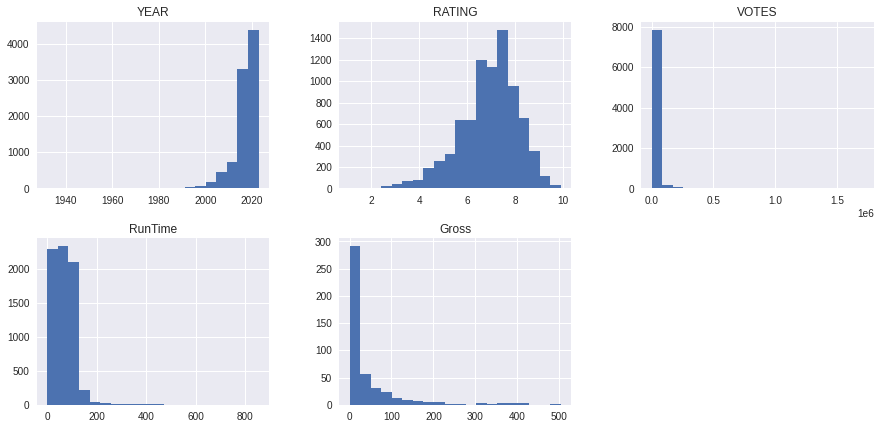

In [ ]:
df.hist(
    figsize=(15,15),
    layout=(4,3),
    bins=20
    );

## 5 - ¿Hay datos duplicados?

*   **duplicated()** devuelve un booleano identificando los casos 
*   **drop_duplicates()** devuelve el DataFrame sin los casos duplicados


In [ ]:
df[df.duplicated()]

,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars
6833,Mighty Little Bheem,2019.0,"Animation, Short, Adventure",NaN,Add a Plot,NaN,NaN,NaN,"Rajiv Chilaka,",None
6835,Mighty Little Bheem,2019.0,"Animation, Short, Adventure",9.0,Add a Plot,6.0,NaN,NaN,"Rajiv Chilaka,",None
6836,Mighty Little Bheem,2019.0,"Animation, Short, Adventure",9.0,Add a Plot,6.0,NaN,NaN,"Rajiv Chilaka,",None
6837,Mighty Little Bheem,2019.0,"Animation, Short, Adventure",NaN,Add a Plot,NaN,NaN,NaN,"Rajiv Chilaka,",None
6838,Mighty Little Bheem,2019.0,"Animation, Short, Adventure",NaN,Add a Plot,NaN,NaN,NaN,"Rajiv Chilaka,",None
...,...,...,...,...,...,...,...,...,...,...
9989,1899,2022.0,"Drama, History, Horror",NaN,Add a Plot,NaN,NaN,NaN,Baran bo Odar,None
9990,1899,2022.0,"Drama, History, Horror",NaN,Add a Plot,NaN,NaN,NaN,Baran bo Odar,None
9991,1899,2022.0,"Drama, History, Horror",NaN,Add a Plot,NaN,NaN,NaN,Baran bo Odar,None
9992,1899,2022.0,"Drama, History, Horror",NaN,Add a Plot,NaN,NaN,NaN,Baran bo Odar,None


Vemos que hay muchos duplicados, pero que algunas filas tienen información que otras no. Queremos eliminar los duplicados y además quedarnos con las que tengan valores en rating en vez de las de nulos.

In [ ]:
# pd.set_option('display.max_rows', None)

In [ ]:
# Creamos una columna que mire si RATING tiene valores o no
df["tiene_rating"] = df["RATING"].to_frame().count(axis=1)

# Ordenamos alfabéticamente (por defecto, ascendentemente) según nombres de películas y la columna nueva
df = df.sort_values(['MOVIES', 'tiene_rating'])

# Borramos las películas que estén más de una vez y nos quedamos con el último valor (que es donde nos aseguramos que tiene_rating=1 en el caso de que suceda)
df = df.drop_duplicates('MOVIES', keep='last')

In [ ]:
# Corroboramos y no hay más duplicados

df[df.duplicated()]



,MOVIES,YEAR,GENRE,RATING,ONE-LINE,VOTES,RunTime,Gross,Director,Stars,tiene_rating


A la hora de tomar una decisión con respecto a los nulos de este DataFrame, deberíamos pensarlo en función de nuestro objetivo.

Ejercicios:

a) ¿Cuáles son los 5 directores mejor puntuados?

b) ¿Cuáles son los 5 actores que más aparecen en la base? ¿Cuáles tienen mejores películas rankeadas?

c) ¿Cuáles son las películas de drama mejor puntuadas?

## Interpolación de series de tiempo.

Veamos un ejemplo en el que queremos realizar interpolaciones para las series temporales, para así obtener nuevos puntos partiendo del conocimiento de un conjunto de puntos.

Comparemos cuatro activos: acciones, bonos, oro y petróleo.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filename = 'https://s3.amazonaws.com/assets.datacamp.com/production/course_4205/datasets/asset_classes.csv'
import urllib.request
urllib.request.urlretrieve(filename, "asset_classes.csv")

('asset_classes.csv', <http.client.HTTPMessage at 0x7ff859ac3f90>)

In [ ]:
prices = pd.read_csv('asset_classes.csv', parse_dates=['DATE'], index_col='DATE')


In [ ]:
prices=prices.astype(int)

In [ ]:
prices = prices.apply(lambda x: x.sample(frac=0.25))

In [ ]:
prices[prices.isna().any(axis=1)]

,SP500,Bonds,Gold,Oil
DATE,,,,
2007-06-29,NaN,NaN,648.0,NaN
2007-07-02,1519.0,NaN,650.0,71.0
2007-07-05,1525.0,400.0,655.0,NaN
2007-07-09,1531.0,NaN,NaN,72.0
2007-07-10,NaN,NaN,661.0,72.0
...,...,...,...,...
2017-06-15,2432.0,NaN,NaN,NaN
2017-06-19,NaN,619.0,1251.0,44.0
2017-06-20,NaN,621.0,NaN,NaN


In [ ]:
prices_16 = prices[prices.index.year==2016]

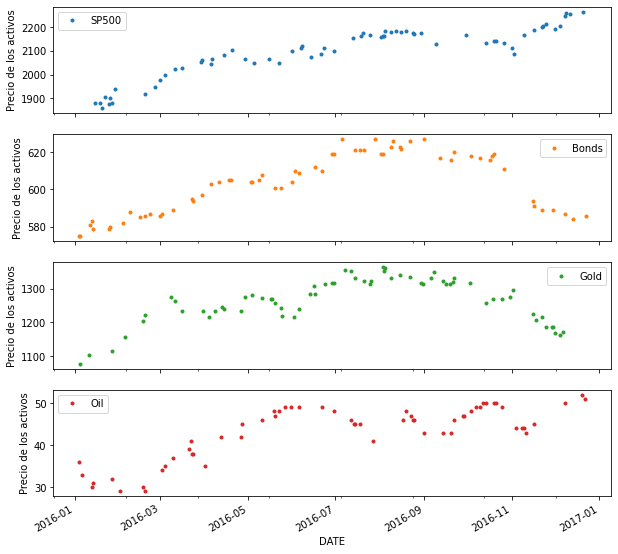

In [ ]:
ejes = prices_16.plot(marker='.', linestyle='None',figsize=(10,10),subplots=True)
for eje in ejes:
  eje.set_ylabel('Precio de los activos')


Podríamos imputar los datos con un fillna()

In [ ]:
prices_b = prices.fillna(method='bfill')

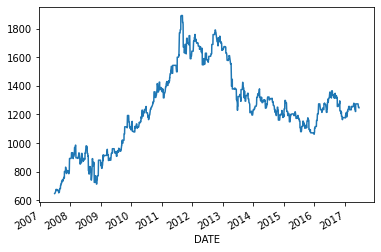

In [ ]:
prices_b.Gold.plot()

In [ ]:
import pandas as pd
import matplotlib.pyplot as  plt
from urllib.request import urlretrieve
plt.style.use('seaborn')

linear = prices_16.interpolate(method='linear')
quadratic = prices_16.interpolate(method='quadratic')
nearest = prices_16.interpolate(method='nearest')

In [ ]:
prices_16 = prices[prices.index.year==2016]

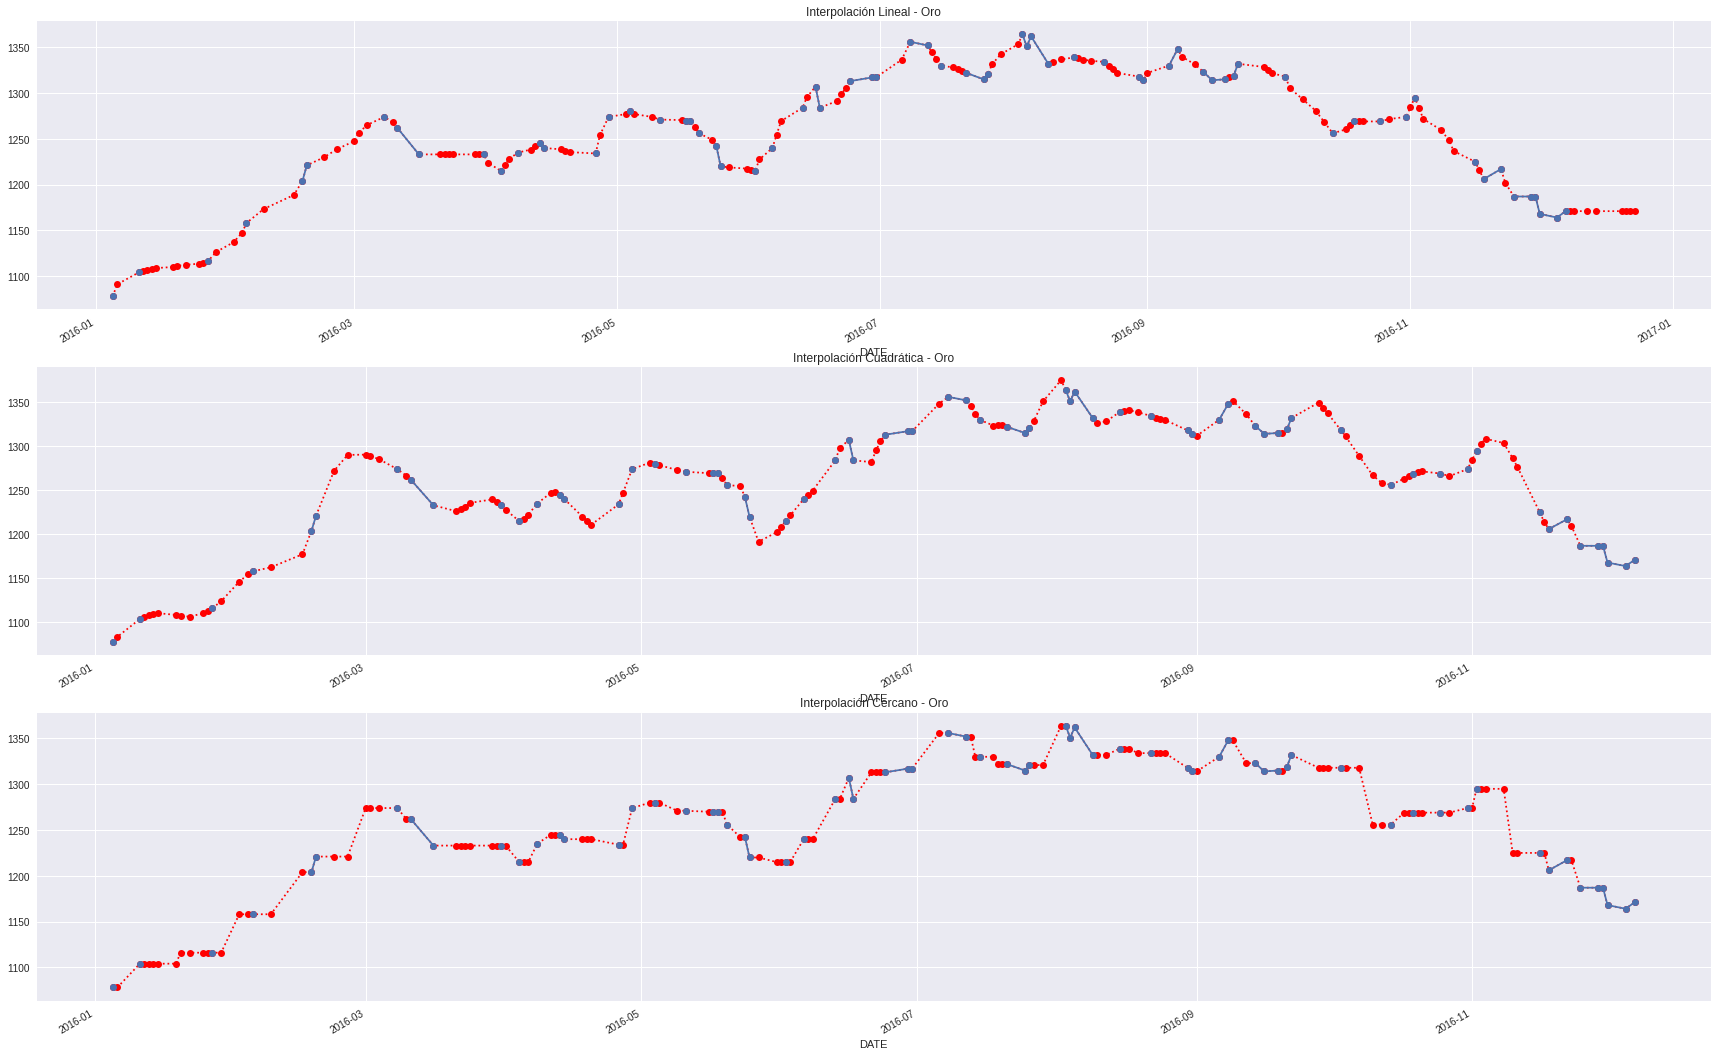

In [ ]:
# Set nrows to 3 and ncols to 1
fig, axes = plt.subplots(3, 1, figsize=(30, 20))

# Create a dictionary of interpolations
interpolations = {'Interpolación Lineal': linear, 'Interpolación Cuadrática': quadratic, 
                  'Interpolación Cercano': nearest}

# Loop over axes and interpolations
for ax, df_key in zip(axes, interpolations):
  # Select and also set the title for a DataFrame
  interpolations[df_key].Gold.plot(color='red', marker='o', 
                                 linestyle='dotted', ax=ax)
  prices_16.Gold.plot(title=df_key + ' - Oro', marker='o', ax=ax)
  
plt.show()

## Ley de Humedales


## Extracción de los datos Web
Datos sobre legisladores y sus posturas frente a la Ley de Humedales. 

Gracias a https://activaelcongreso.ar por la data. 

Pasos para el scraping:
- Identificar el tema a investigar
- Identificar una fuente de datos (activaelcongreso.ar)
- Dentro del sitio, ver dónde se renderizan los datos:
https://activaelcongreso.ar/p/Ley_de_Humedales_Ya/politicos 
- Aplicar lo que se ve en la clase de APIs Ocultas (agregar link):
  - Abrimos ChromeDevTools
  - Vamos a la pestaña Network
  - Identificamos (podemos usar el buscador) los requests que contienen la info
  - Copiamos el request como cURL, y usamos algo como https://curlconverter.com/ para convertirlo a Python
  - Identificamos la parte central del request, quitando los cookies y headers no esenciales

Con eso podemos bajar los distintos jsons que necesitamos, y unirlos para armar la tabla con datos útiles.

In [ ]:
# Bajamos datos encontrados en distintos requests

import requests

json_data = {
    'type': 'TipoPolitico',
    'action': 'get',
    'params': {},
}

response = requests.post('https://activaelcongreso.ar/PHP/api.php', json=json_data)
response.json()

[{'id': '2', 'nombre': 'Senadorxs'}, {'id': '3', 'nombre': 'Diputadxs'}]

## Pydantic



### Repaso
Cuando armamos aplicaciones con distintos componentes, es útil ir más allá del **tipado dinámico** y definir los típos de datos y **esquemas** que esperamos. Definamos un primer ejemplo de juguete:

In [ ]:
from typing import Optional
from pydantic import BaseModel, Field

class SuperDict(BaseModel):
  '''
  Field nos permite especificar caracteristicas del campo, como descripcion o restricciones.
  Podemos dejar campos como opcionales con Optional.
  '''
  id: int = Field(ge=1)
  nombre: str = Field(min_length=1, max_length=30)
  altura: Optional[float] = Field(ge=0, le=300, description="Altura en cm.")

In [ ]:
SuperDict(id=1, nombre='Ernesto', altura=170.0)

SuperDict(id=1, nombre='Ernesto', altura=170.0)

In [ ]:
caso = {"id": 2, "nombre": ""}

In [ ]:
from pydantic import ValidationError

try:
  SuperDict(**caso)
except ValidationError as e:
  print(e)

1 validation error for SuperDict
nombre
  ensure this value has at least 1 characters (type=value_error.any_str.min_length; limit_value=1)


In [ ]:
# Info sobre los bloques
json_data = {
    'type': 'Bloque',
    'action': 'get',
    'params': {},
}

bloques = requests.post('https://activaelcongreso.ar/PHP/api.php', json=json_data).json()

In [ ]:
bloques

[{'id': '4',
  'foto': 'bloque-4.jpg',
  'nombre': 'Frente de Todos',
  'color': '4fc3f7'},
 {'id': '6', 'foto': 'bloque-6.jpg', 'nombre': 'PRO', 'color': 'fdd835'},
 {'id': '7',
  'foto': 'bloque_default.jpg',
  'nombre': 'Producción y Trabajo',
  'color': '000000'},
 {'id': '9',
  'foto': 'bloque_default.jpg',
  'nombre': 'Unidad y Equidad por San Luis',
  'color': '000000'},
 {'id': '11',
  'foto': 'bloque-11.jpg',
  'nombre': 'Unión Cívica Radical',
  'color': 'b71c1c'},
 {'id': '12',
  'foto': 'bloque-12.jpg',
  'nombre': 'Partido por la Justicia Social',
  'color': '01579b'},
 {'id': '13',
  'foto': 'bloque-13.jpg',
  'nombre': 'Justicialista',
  'color': '0288d1'},
 {'id': '14',
  'foto': 'bloque-14.jpg',
  'nombre': 'Consenso Federal',
  'color': '1a237e'},
 {'id': '18',
  'foto': 'bloque-18.jpg',
  'nombre': 'Córdoba Federal',
  'color': '29b6f6'},
 {'id': '19',
  'foto': 'bloque-19.jpg',
  'nombre': 'Coalición Cívica',
  'color': '01579b'},
 {'id': '21',
  'foto': 'bloque-21.

Podemos validar el dato que esperamos con un esquema de pydantic.

### Ejemplo Bloques

In [ ]:
class BloqueID(BaseModel):
  id: int
  foto: str
  nombre: str
  color: str

In [ ]:
# Podemos validar todos los bloques que nos trajo la API
[BloqueID(**b) for b in bloques][:5]

[BloqueID(id=4, foto='bloque-4.jpg', nombre='Frente de Todos', color='4fc3f7'),
 BloqueID(id=6, foto='bloque-6.jpg', nombre='PRO', color='fdd835'),
 BloqueID(id=7, foto='bloque_default.jpg', nombre='Producción y Trabajo', color='000000'),
 BloqueID(id=9, foto='bloque_default.jpg', nombre='Unidad y Equidad por San Luis', color='000000'),
 BloqueID(id=11, foto='bloque-11.jpg', nombre='Unión Cívica Radical', color='b71c1c')]

Podemos hacer validaciones personalizadas, como validar que el campo de  `foto` termine con `jpg` usando el **decorador `validator`**

In [ ]:
from pydantic import validator

class BloqueID(BaseModel):
  id: int
  foto: str
  nombre: str
  color: str

  @validator('foto')
  def validate_photo(cls, v):
    assert v.endswith('jpg'), 'No termina con JPG'
    return v

O validar que el campo "nombre" pertenezca a una lista de nombres predefinidos

In [ ]:
from typing import List
from enum import Enum

class Bloque(Enum):
  FRENTE_DE_TODOS = 'Frente de Todos'
  PRO = 'PRO'
  PRODUCCIÓN_Y_TRABAJO = 'Producción y Trabajo'
  UNIDAD_Y_EQUIDAD_POR_SAN_LUIS = 'Unidad y Equidad por San Luis'
  UNIÓN_CÍVICA_RADICAL = 'Unión Cívica Radical'
  PARTIDO_POR_LA_JUSTICIA_SOCIAL = 'Partido por la Justicia Social'
  JUSTICIALISTA = 'Justicialista'
  CONSENSO_FEDERAL = 'Consenso Federal'
  CÓRDOBA_FEDERAL = 'Córdoba Federal'
  COALICIÓN_CÍVICA = 'Coalición Cívica'
  FRENTE_PROGRESISTA_CÍVICO_Y_SOCIAL = 'Frente Progresista Cívico y Social'
  PTS_FRENTE_DE_IZQUIERDA = 'PTS - Frente de Izquierda'
  SOCIALISTA = 'Socialista'
  JUNTOS_SOMOS_RIO_NEGRO = 'Juntos Somos Rio Negro'
  FRENTE_DE_IZQUIERDA_Y_DE_LOS_TRABAJADORES = 'Frente de Izquierda y de los Trabajadores - Unidad'
  FRENTE_DE_LA_CONCORDIA_MISIONERO = 'Frente de la Concordia Misionero'
  MOVIMIENTO_POPULAR_NEUQUINO = 'Movimiento Popular Neuquino'
  ACCION_FEDERAL = 'Acción Federal'
  FRENTE_CÍVICO_Y_SOCIAL_DE_CATAMARCA = 'Frente Cívico y Social de Catamarca'
  FUERZA_CÍVICA_RIOJANA = 'Fuerza Cívica Riojana'
  AVANZAR_SAN_LUIS = 'Avanzar San Luis'
  SANTA_FE_FEDERAL = 'Santa Fe Federal'
  JUSTICIALISTA_8_DE_OCTUBRE = 'Justicialista 8 de Octubre'
  MISIONES = 'Misiones '
  UNIDAD_FEDERAL_PARA_EL_DESARROLLO = 'Unidad Federal para el Desarrollo'
  AVANZA_LIBERTAD = 'Avanza Libertad'
  AHORA_PATRIA = 'Ahora Patria'
  IDENTIDAD_BONAERENSE_ = 'Identidad Bonaerense '
  EVOLUCIÓN_RADICAL = 'Evolución Radical'
  ENCUENTRO_FEDERAL = 'Encuentro Federal'
  CREO = 'Creo'
  IZQUIERDA_SOCIALISTA_FRENTE_DE_IZQUIERDA = 'Izquierda Socialista - Frente de Izquierda'
  LA_LIBERTAD_AVANZA = 'La Libertad Avanza'
  UNIDOS_POR_SAN_LUIS = 'Unidos por San Luis'
  PARTIDO_OBRERO_FRENTE_DE_IZQUIERDA_Y_DE_LOS_TRABAJADORES_UNIDAD = 'Partido Obrero - Frente de Izquierda y de los Trabajadores - Unidad'
  PTS_FRENTE_DE_IZQUIERDA_DE_TRABAJADORES_UNIDAD = 'PTS - Frente de Izquierda de Trabajadores - Unidad'
  REPUBLICANOS_UNIDOS_ = 'Republicanos Unidos '
  SIN_BLOQUE = 'Sin Bloque'
  SER_SOMOS_ENERGÍA_PARA_RENOVAR = 'SER - Somos Energía para Renovar'
  UNIDAD_Y_EQUIDAD_FEDERAL = 'Unidad y Equidad Federal'

### Ejemplo con Enum

In [ ]:
from pydantic import validator

class BloqueID(BaseModel):
  id: int
  foto: str
  # Bloque ahora solo puede ser alguno de los valores de arriba
  nombre: Bloque
  color: str

  @validator('foto')
  def validate_photo(cls, v):
    assert v.endswith('jpg'), 'No termina con JPG'
    return v

In [ ]:
BloqueID(**bloques[0])

BloqueID(id=4, foto='bloque-4.jpg', nombre=<Bloque.FRENTE_DE_TODOS: 'Frente de Todos'>, color='4fc3f7')

In [ ]:
bloque = {'id': '4',
          'foto': 'bloque-4.jpg',
          'nombre':'Frente de Algunos',
          'color': '4fc3f7'}

In [ ]:
BloqueID(**bloque)

ValidationError: ignored

¿Cómo podemos hacer para normalizar y reparar casos como este? Veremos cómo hacerlo con **búsqueda difusa de strings**

### Ejercicio Pydantic

1. Crear un esquema de PyDantic que valide el siguiente JSON de `Politico`. 
2. Crear otro esquema para `Sexo` que valide que el número en ese campo sea uno de los dos permitidos (0,1). Hacer que `Politico` tenga un campo `Sexo`.
3. Agregar validación para la fecha de nacimiento y para el mail (se podría pensar una validación usando REGEX para el mail)

## Distancia de edición 


Para afrontar el "ruido" en nuestros textos, tenemos una importante herramienta: la distancia de edición.

También llamada Distancia de Levenshtein, nos dice la cantidad mínima de operaciones requerida para llevar de un string al otro. Expresandola de una manera sencilla (y en su versión sin normalizar entre 0 y 1) podemos explicarla así:

$$\mathit{L} = S+D+I$$

Donde $S$ = sustitución, $D$ = Eliminación, $I$ = inserción (de un caracter).


También podemos usarla entre dos listas como métrica de similitud.

In [ ]:
from nltk.metrics import edit_distance

In [ ]:
# Definimos una lista de tuplas de palabras
palabras = [("pero", "perro"),("pero", "pierdo"), ("nueve", "mueve"),  ("totalmente","diferentes"), ("pero", "basta")]

for x,y in palabras:
    print(f"'{x}' vs '{y}':")
    print("Distancia Levenshtein ->", edit_distance(x,y))
    print("-"*40)

'pero' vs 'perro':
Distancia Levenshtein -> 1
----------------------------------------
'pero' vs 'pierdo':
Distancia Levenshtein -> 2
----------------------------------------
'nueve' vs 'mueve':
Distancia Levenshtein -> 1
----------------------------------------
'totalmente' vs 'diferentes':
Distancia Levenshtein -> 7
----------------------------------------
'pero' vs 'basta':
Distancia Levenshtein -> 5
----------------------------------------


## Búsqueda difusa de strings (fuzzy string matching)



Técnica muy útil para tener en el repertorio, nos permite encontrar coincidencias que no son exactas. En el caso más sencillo, la búsqueda difusa nos devolverá un puntaje de similitud entre los strings relacionada a las diferencias entre los caracteres. Existen variaciones que consideran cuántas unidades (palabras, tokens) coinciden, que ordenan la oración antes, o que borran repetidos. 

Hay distintas alternativas, que pueden separar en palabras, ordenarlas, borrar duplicadas, o calcular la superposicion del string directamente. Pueden ver todas las disponibles en: https://github.com/seatgeek/thefuzz 

In [ ]:
%%capture
!pip install thefuzz[speedup]
from thefuzz import process, fuzz

In [ ]:
c1 = 'uno dos tres'
c2 = 'uno doce trece'
fuzz.ratio(c1, c2) # entre 0 y 100

77

Podemos usar esta función para encontrar la mejor coincidencia para una palabra en una lista de candidatos:

In [ ]:
def get_match(string, lista_strings):
    """Para buscar coincidencias entre nombre con los nombres"""
    mejor_match, puntaje = process.extractBests(string.strip(), lista_strings, scorer=fuzz.ratio)[0]
    return mejor_match, puntaje

In [ ]:
bloques

[{'id': '4',
  'foto': 'bloque-4.jpg',
  'nombre': 'Frente de Todos',
  'color': '4fc3f7'},
 {'id': '6', 'foto': 'bloque-6.jpg', 'nombre': 'PRO', 'color': 'fdd835'},
 {'id': '7',
  'foto': 'bloque_default.jpg',
  'nombre': 'Producción y Trabajo',
  'color': '000000'},
 {'id': '9',
  'foto': 'bloque_default.jpg',
  'nombre': 'Unidad y Equidad por San Luis',
  'color': '000000'},
 {'id': '11',
  'foto': 'bloque-11.jpg',
  'nombre': 'Unión Cívica Radical',
  'color': 'b71c1c'},
 {'id': '12',
  'foto': 'bloque-12.jpg',
  'nombre': 'Partido por la Justicia Social',
  'color': '01579b'},
 {'id': '13',
  'foto': 'bloque-13.jpg',
  'nombre': 'Justicialista',
  'color': '0288d1'},
 {'id': '14',
  'foto': 'bloque-14.jpg',
  'nombre': 'Consenso Federal',
  'color': '1a237e'},
 {'id': '18',
  'foto': 'bloque-18.jpg',
  'nombre': 'Córdoba Federal',
  'color': '29b6f6'},
 {'id': '19',
  'foto': 'bloque-19.jpg',
  'nombre': 'Coalición Cívica',
  'color': '01579b'},
 {'id': '21',
  'foto': 'bloque-21.

In [ ]:
nombres_bloques = [b["nombre"] for b in bloques]

In [ ]:
nombres_bloques

['Frente de Todos',
 'PRO',
 'Producción y Trabajo',
 'Unidad y Equidad por San Luis',
 'Unión Cívica Radical',
 'Partido por la Justicia Social',
 'Justicialista',
 'Consenso Federal',
 'Córdoba Federal',
 'Coalición Cívica',
 'Frente Progresista Cívico y Social',
 'PTS - Frente de Izquierda',
 'Socialista',
 'Juntos Somos Rio Negro',
 'Frente de Izquierda y de los Trabajadores - Unidad',
 'Frente de la Concordia Misionero',
 'Movimiento Popular Neuquino',
 'Acción Federal',
 'Frente Cívico y Social de Catamarca',
 'Fuerza Cívica Riojana',
 'Avanzar San Luis',
 'Santa Fe Federal',
 'Justicialista 8 de Octubre',
 'Misiones ',
 'Unidad Federal para el Desarrollo',
 'Avanza Libertad',
 'Ahora Patria',
 'Identidad Bonaerense ',
 'Evolución Radical',
 'Encuentro Federal',
 'Creo',
 'Izquierda Socialista - Frente de Izquierda',
 'La Libertad Avanza',
 'Unidos por San Luis',
 'Partido Obrero - Frente de Izquierda y de los Trabajadores - Unidad',
 'PTS - Frente de Izquierda de Trabajadores - 

In [ ]:
busqueda = 'Frente de Algunos'
get_match(busqueda, nombres_bloques)

('Frente de Todos', 75)

## Ejercicio: búsqueda difusa
Dado el siguiente DataFrame, aplicar la búsqueda difusa de strings para la primera palabra de la descripción de cada producto (columna denominación)

In [ ]:
# http://datos.salud.gob.ar/dataset/alimentos-libres-de-gluten/archivo/853d467c-5de5-46ae-bf04-5642c4960d1d
import pandas as pd
url = "http://datos.salud.gob.ar/dataset/2ebd602e-3138-40c0-847a-f3eb8f520887/resource/853d467c-5de5-46ae-bf04-5642c4960d1d/download/alimentos-libres-de-gluten.csv"
df = pd.read_csv(url)

In [ ]:
df

,marca,nombre_fantasia,denominacion,RNPA
0,Abedul,No registra,"Aceite de maíz, libre de gluten, sin TACC",02-508542
1,Abedul,No registra,Aceite de maíz - Libre de gluten,02-519714
2,Abedul,No registra,Aceite de oliva virgen libre de gluten.,02-598508
3,Alimentos Tomy,No registra,Aceite de oliva extra libre de gluten,03003988-2
4,Almalegre,No registra,Aceite de oliva virgen extra – Libre de gluten,13043916
...,...,...,...,...
14700,Valle del Carmen,No registra,Yogur entero bebible endulzado sabor a frutill...,21-099259
14701,Valle del Carmen,No registra,Yogur entero bebible endulzado sabor a vainill...,21-099261
14702,Valle del Carmen,No registra,Yogur entero endulzado bebible sabor a durazno...,21-099258
14703,Enjoy - Kuhne,Balsámico Vinaigrette,Aderezo a base de vinagre de vino - Libre de g...,056-00-009851


# Bonus:
- Aplicar la normalización sobre los nombres completos de los productos.

Va a requerrir un poco más de pasos, ej podrían borrar "sin TACC" (usar RegEx), "libre de gluten"